# Introduction
This notebook performs some basic exploratory data analysis of the New York Rolling Sales data from the [Doing Data Science : Straight Talk from the Frontline book][booklink] by Cathy O'Neil & Rachel Schutt published by O'Reilly Media. The data can be downloaded [here][datalink] and specifically I will be briefly looking at the `rollingsales_manhattan.xls` data.

The file contains housing sales data for Manhattan properties, including the neighbourhood, building class (family home, condo, etc), sale price, sale date, etc. 

I will be doing the data analysis using Julia.

[booklink]: https://www.oreilly.com/library/view/doing-data-science/9781449363871/
[datalink]: https://github.com/oreillymedia/doing_data_science

# Open and clean the data
After getting the data from github and extracting the zip files let's import the data into a dataframe. I'll be using [Queryverse][https://github.com/queryverse/Queryverse.jl] which contains a number of useful packages for data science.

First I import the packages I want to use, then I load in the excel file. Queryverse.jl contains Query.jl which uses ExcelFiles.jl to import Excel files. It just so happens that this data is contained within an excel file! I restricted the range of the data as the first 4 rows were some notes that I wanted to omit from the import. After this I do a bit of data cleaning.

In [1]:
using DataFrames, Gadfly, Queryverse, Statistics, Dates
D = DataFrame(load("./rollingsales_manhattan.xls", "Manhattan!A5:U27400"));

In [2]:
# We can inspect the data by using the first() command. This is similar to the pandas head function. We are also interested in the size of the DataFrame
println(string("The size of the DataFrame is ",size(D)))
first(D,5)

The size of the DataFrame is (27395, 21)


5×21 DataFrame. Omitted printing of 19 columns
│ Row │ BOROUGH │ NEIGHBORHOOD              │
│     │ Float64 │ String                    │
├─────┼─────────┼───────────────────────────┤
│ 1   │ 1.0     │                           │
│ 2   │ 1.0     │                           │
│ 3   │ 1.0     │                           │
│ 4   │ 1.0     │                           │
│ 5   │ 1.0     │                           │

In [3]:
# We see that we have 27395 data rows each containing 21 data points. The output of first() was restricted so let's take a look at the names of the columns using propertynames.
println(propertynames(D))

[:BOROUGH, :NEIGHBORHOOD, Symbol("BUILDING CLASS CATEGORY"), Symbol("TAX CLASS AT PRESENT"), :BLOCK, :LOT, Symbol("EASE-MENT"), Symbol("BUILDING CLASS AT PRESENT"), :ADDRESS, Symbol("APART\nMENT\nNUMBER"), Symbol("ZIP CODE"), Symbol("RESIDENTIAL UNITS"), Symbol("COMMERCIAL UNITS"), Symbol("TOTAL UNITS"), Symbol("LAND SQUARE FEET"), Symbol("GROSS SQUARE FEET"), Symbol("YEAR BUILT"), Symbol("TAX CLASS AT TIME OF SALE"), Symbol("BUILDING CLASS AT TIME OF SALE"), Symbol("SALE\nPRICE"), Symbol("SALE DATE")]


In [4]:
# This is non-ideal, as some names have spaces and some others have new line characters in the middle. Lets clean these up and also change EASE-MENT to EASEMENT as well.
for pn in propertynames(D)
  rename!(D,pn => Symbol(filter(x -> !isspace(x),string(pn))))
  rename!(D,pn => Symbol(replace(string(pn),"-"=> "")))
end
println(propertynames(D))

[:BOROUGH, :NEIGHBORHOOD, :BUILDINGCLASSCATEGORY, :TAXCLASSATPRESENT, :BLOCK, :LOT, :EASEMENT, :BUILDINGCLASSATPRESENT, :ADDRESS, :APARTMENTNUMBER, :ZIPCODE, :RESIDENTIALUNITS, :COMMERCIALUNITS, :TOTALUNITS, :LANDSQUAREFEET, :GROSSSQUAREFEET, :YEARBUILT, :TAXCLASSATTIMEOFSALE, :BUILDINGCLASSATTIMEOFSALE, :SALEPRICE, :SALEDATE]


In [5]:
# Next, lets take a look at the types of data in each column
[println(string(pn, ": " , typeof(D[:,pn]))) for pn in propertynames(D)];
# Most of the categories are either Floats or Strings, however TAXCLASSATPRESENT and APARTMENTNUMBER are Any as some are Floats (e.g. Apartment 1, 2, etc) and some are Strings (e.g. 1A, 2B, etc). The SALEDATE column has been imported as a DateTime objects, fortunately.

BOROUGH: Array{Float64,1}
NEIGHBORHOOD: Array{String,1}
BUILDINGCLASSCATEGORY: Array{String,1}
TAXCLASSATPRESENT: Array{Any,1}
BLOCK: Array{Float64,1}
LOT: Array{Float64,1}
EASEMENT: Array{String,1}
BUILDINGCLASSATPRESENT: Array{String,1}
ADDRESS: Array{String,1}
APARTMENTNUMBER: Array{Any,1}
ZIPCODE: Array{Float64,1}
RESIDENTIALUNITS: Array{Float64,1}
COMMERCIALUNITS: Array{Float64,1}
TOTALUNITS: Array{Float64,1}
LANDSQUAREFEET: Array{Float64,1}
GROSSSQUAREFEET: Array{Float64,1}
YEARBUILT: Array{Float64,1}
TAXCLASSATTIMEOFSALE: Array{Float64,1}
BUILDINGCLASSATTIMEOFSALE: Array{String,1}
SALEPRICE: Array{Float64,1}
SALEDATE: Array{Dates.DateTime,1}


In [6]:
# To ensure consistency, I'm going to make the String columns lower case, just in case there are any mixed cases that may cause problems later on. I also remove any spaces. I found two ways of doing this, the latter appearing to execute marginally more quickly when run from a script.

# Using DataFrames
#for pn in propertynames(D)
#  if typeof(D[:,pn]) == Array{String,1}
#    D[:,pn] = map(lowercase,map(join,map(split,D[:,pn])));
#  end
#end

# Using the QueryVerse Data Pipeline method
D = D |> @mutate(NEIGHBORHOOD = lowercase(join(split(strip(_.NEIGHBORHOOD)))),BUILDINGCLASSCATEGORY = lowercase(join(split(strip(_.BUILDINGCLASSCATEGORY)))),ADDRESS = lowercase(join(split(strip(_.ADDRESS)))),EASEMENT = lowercase(join(split(strip(_.EASEMENT)))),BUILDINGCLASSATPRESENT = lowercase(join(split(strip(_.BUILDINGCLASSATPRESENT)))),BUILDINGCLASSATTIMEOFSALE = lowercase(join(split(strip(_.BUILDINGCLASSATTIMEOFSALE))))) |> DataFrame

27395×21 DataFrame. Omitted printing of 18 columns
│ Row   │ BOROUGH │ NEIGHBORHOOD           │ BUILDINGCLASSCATEGORY       │
│       │ Float64 │ String                 │ String                      │
├───────┼─────────┼────────────────────────┼─────────────────────────────┤
│ 1     │ 1.0     │                        │ 13condos-elevatorapartments │
│ 2     │ 1.0     │                        │ 13condos-elevatorapartments │
│ 3     │ 1.0     │                        │ 13condos-elevatorapartments │
│ 4     │ 1.0     │                        │ 13condos-elevatorapartments │
│ 5     │ 1.0     │                        │ 13condos-elevatorapartments │
│ 6     │ 1.0     │                        │ 13condos-elevatorapartments │
│ 7     │ 1.0     │                        │ 13condos-elevatorapartments │
│ 8     │ 1.0     │                        │ 13condos-elevatorapartments │
│ 9     │ 1.0     │                        │ 13condos-elevatorapartments │
│ 10    │ 1.0     │                        │ 13condos-elevatorapartments │
⋮
│ 27385 │ 1.0     │ washingtonheightsupper │ 29commercialgarages         │
│ 27386 │ 1.0     │ washingtonheightsupper │ 29commercialgarages         │
│ 27387 │ 1.0     │ washingtonheightsupper │ 29commercialgarages         │
│ 27388 │ 1.0     │ washingtonheightsupper │ 31commercialvacantland      │
│ 27389 │ 1.0     │ washingtonheightsupper │ 31commercialvacantland      │
│ 27390 │ 1.0     │ washingtonheightsupper │ 31commercialvacantland      │
│ 27391 │ 1.0     │ washingtonheightsupper │ 31commercialvacantland      │
│ 27392 │ 1.0     │ washingtonheightsupper │ 31commercialvacantland      │
│ 27393 │ 1.0     │ washingtonheightsupper │ 31commercialvacantland      │
│ 27394 │ 1.0     │ washingtonheightsupper │ 31commercialvacantland      │
│ 27395 │ 1.0     │ washingtonheightsupper │ 31commercialvacantland      │

# Filtering the data, basic data analysis & adding new features

We are going to be interested in the sale price and how this varies with different neighbourhoods and building area (gross square feet). Some of the prices are \$0, so we'll ignore those (I assume they didn't sell), and some of the prices are very low so I'll filter out those with sale prices below \$100,000. We also want to filter out datapoints that have 0 sqf gross area.

We'll also perform some basic analysis looking at how the building type (condo, family home, etc) and the neighbourhood affects the average price per square foot.

In [31]:
# Lets plot some of the sale prices, I'll filter out those that are above $100,000 because we're interested in the outliers. I find plotting to be very slow in my nteract notebook, I'm not sure why - I have no problems when using the JuliaPro IDE. Below is one way of performing the plot and the cell below shows another way of doing it. They should give equivalent plots.
D |> @filter(_.SALEPRICE < 100000 && _.SALEPRICE >0 ) |> @vlplot(:circle,x={"SALEDATE:t",axis = {format="%m%Y"}},y={:SALEPRICE,scale={type="log",base=10}},color=:NEIGHBORHOOD)


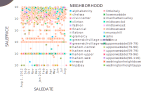

In [7]:
q = D |> @filter(_.SALEPRICE < 100000 && _.SALEPRICE >0 ) |> DataFrame;
plot(q,x=:SALEDATE,y=:SALEPRICE,Geom.point,Scale.y_log10,color=:NEIGHBORHOOD)
# From the plot we see that we have many properties that appear to have a saleprice of exactly 10^n, which seems suspicious. A lot of the properties appear to be in a particular region - Mid Town West.

In [19]:
println(q |>
    @groupby(_.NEIGHBORHOOD) |>
    @map({Key=key(_), Count=length(_)}) |>
    DataFrame)

32×2 DataFrame
│ Row │ Key                      │ Count │
│     │ String                   │ Int64 │
├─────┼──────────────────────────┼───────┤
│ 1   │ alphabetcity             │ 4     │
│ 2   │ chelsea                  │ 24    │
│ 3   │ civiccenter              │ 4     │
│ 4   │ clinton                  │ 7     │
│ 5   │ fashion                  │ 3     │
│ 6   │ financial                │ 3     │
│ 7   │ flatiron                 │ 8     │
│ 8   │ gramercy                 │ 8     │
│ 9   │ greenwichvillage-central │ 6     │
│ 10  │ greenwichvillage-west    │ 9     │
│ 11  │ harlem-central           │ 46    │
│ 12  │ harlem-east              │ 16    │
│ 13  │ harlem-upper             │ 9     │
│ 14  │ harlem-west              │ 9     │
│ 15  │ inwood                   │ 1     │
│ 16  │ kipsbay                  │ 8     │
│ 17  │ littleitaly              │ 2     │
│ 18  │ lowereastside            │ 5     │
│ 19  │ manhattanvalley          │ 6     │
│ 20  │ midtowncbd               │ 5   

In [20]:
# Looking further at the data we can see that the majority of the building class is either empty or Luxury Hotels. Perhaps the cost is so low in the latter case as it is possible to invest in each individual hotel room?
println(q |>
    @groupby(_.BUILDINGCLASSCATEGORY) |>
    @map({Key=key(_), Count=length(_)}) |>
    DataFrame)

24×2 DataFrame
│ Row │ Key                                 │ Count │
│     │ String                              │ Int64 │
├─────┼─────────────────────────────────────┼───────┤
│ 1   │ 07rentals-walkupapartments          │ 26    │
│ 2   │ 09coops-walkupapartments            │ 39    │
│ 3   │ 12condos-walkupapartments           │ 1     │
│ 4   │ 31commercialvacantland              │ 3     │
│ 5   │                                     │ 1129  │
│ 6   │ 10coops-elevatorapartments          │ 98    │
│ 7   │ 13condos-elevatorapartments         │ 89    │
│ 8   │ 23loftbuildings                     │ 2     │
│ 9   │ 28commercialcondos                  │ 365   │
│ 10  │ 16condos-2-10unitwithcommercialunit │ 1     │
│ 11  │ 33educationalfacilities             │ 1     │
│ 12  │ 17condops                           │ 19    │
│ 13  │ 02twofamilyhomes                    │ 7     │
│ 14  │ 03threefamilyhomes                  │ 1     │
│ 15  │ 08rentals-elevatorapartments        │ 4     │
│ 16  │ 11aco

In [33]:
# Lets see if some Neighbourhoods have a higher chance of having a non-zero Sale Price (i.e. the property sold).
println(D |>
    @groupby(_.NEIGHBORHOOD) |>
    @map({Key=key(_), Count=length(_),PropSold = sum(_.SALEPRICE .>0 )./length(_)}) |>
    DataFrame)

40×3 DataFrame
│ Row │ Key                      │ Count │ PropSold │
│     │ String                   │ Int64 │ Float64  │
├─────┼──────────────────────────┼───────┼──────────┤
│ 1   │                          │ 17    │ 1.0      │
│ 2   │ alphabetcity             │ 149   │ 0.785235 │
│ 3   │ chelsea                  │ 1028  │ 0.818093 │
│ 4   │ chinatown                │ 168   │ 0.714286 │
│ 5   │ civiccenter              │ 244   │ 0.811475 │
│ 6   │ clinton                  │ 517   │ 0.553191 │
│ 7   │ eastvillage              │ 208   │ 0.788462 │
│ 8   │ fashion                  │ 230   │ 0.721739 │
│ 9   │ financial                │ 503   │ 0.819085 │
│ 10  │ flatiron                 │ 554   │ 0.633574 │
│ 11  │ gramercy                 │ 539   │ 0.834879 │
│ 12  │ greenwichvillage-central │ 757   │ 0.82959  │
│ 13  │ greenwichvillage-west    │ 709   │ 0.763047 │
│ 14  │ harlem-central           │ 811   │ 0.808878 │
│ 15  │ harlem-east              │ 329   │ 0.693009 │
│ 16  │ harle

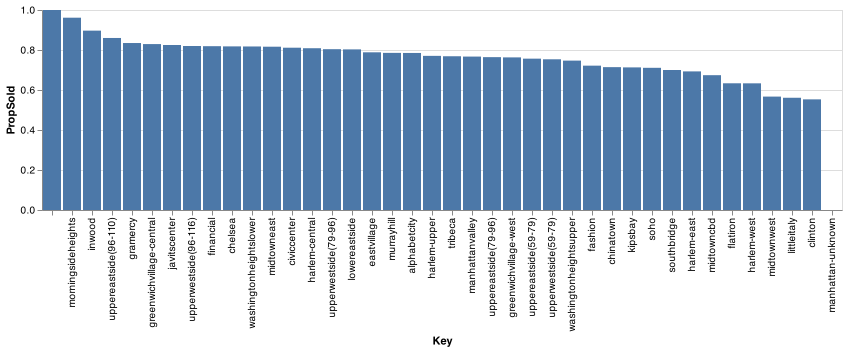

In [46]:
D |> @groupby(_.NEIGHBORHOOD) |> @map({Key=key(_), Count=length(_),PropSold = sum(_.SALEPRICE .>0 )./length(_)}) |> @orderby_descending(_.PropSold) |> @vlplot(:bar,x={:Key,sort="-y"},y={:PropSold})


It looks like Midtown West, Little Italy, and Clinton have the lowest proportion of sold to listed properties. Clinton and Midtown West are very close together, so this makes sense. At the othere end of the scale Morningside Heights, Inwood, and Upper East Side (96-110th St) stand out.

In [47]:
# Lets also look at some descriptive stats on the sale price and building area.
println(describe(D[:,:SALEPRICE]))
println(describe(D[:,:GROSSSQUAREFEET]))

Summary Stats:
Length:         27395
Missing Count:  0
Mean:           1848000.652783
Minimum:        0.000000
1st Quartile:   0.000000
Median:         450000.000000
3rd Quartile:   1150000.000000
Maximum:        1307965050.000000
Type:           Float64
nothing
Summary Stats:
Length:         27395
Missing Count:  0
Mean:           9572.026319
Minimum:        0.000000
1st Quartile:   0.000000
Median:         0.000000
3rd Quartile:   0.000000
Maximum:        1970736.000000
Type:           Float64
nothing


In [48]:
# Filter out those data points that we're not interested in, this reduces the size of the DataFrame significantly
println(size(D))
D = D |> @filter(_.SALEPRICE > 100000 && _.GROSSSQUAREFEET >0) |> @mutate(PRICEPERSQF = _.SALEPRICE/_.GROSSSQUAREFEET) |> DataFrame;
println(size(D))

(27395, 21)
(1669, 22)


In [50]:
# Now we'll start by looking at family homes
D = D |> @mutate(FAMILYHOME = occursin("family",_.BUILDINGCLASSCATEGORY)) |> DataFrame
D_fam = D |> @filter(_.FAMILYHOME == true) |> DataFrame

291×23 DataFrame. Omitted printing of 20 columns
│ Row │ BOROUGH │ NEIGHBORHOOD           │ BUILDINGCLASSCATEGORY │
│     │ Float64 │ String                 │ String                │
├─────┼─────────┼────────────────────────┼───────────────────────┤
│ 1   │ 1.0     │ alphabetcity           │ 03threefamilyhomes    │
│ 2   │ 1.0     │ chelsea                │ 01onefamilyhomes      │
│ 3   │ 1.0     │ chelsea                │ 01onefamilyhomes      │
│ 4   │ 1.0     │ chelsea                │ 01onefamilyhomes      │
│ 5   │ 1.0     │ chelsea                │ 01onefamilyhomes      │
│ 6   │ 1.0     │ chelsea                │ 01onefamilyhomes      │
│ 7   │ 1.0     │ chelsea                │ 02twofamilyhomes      │
│ 8   │ 1.0     │ chelsea                │ 03threefamilyhomes    │
│ 9   │ 1.0     │ chelsea                │ 03threefamilyhomes    │
│ 10  │ 1.0     │ chinatown              │ 02twofamilyhomes      │
⋮
│ 281 │ 1.0     │ washingtonheightslower │ 02twofamilyhomes      │
│ 282 │ 1.0     │ washingtonheightslower │ 02twofamilyhomes      │
│ 283 │ 1.0     │ washingtonheightslower │ 02twofamilyhomes      │
│ 284 │ 1.0     │ washingtonheightslower │ 03threefamilyhomes    │
│ 285 │ 1.0     │ washingtonheightsupper │ 01onefamilyhomes      │
│ 286 │ 1.0     │ washingtonheightsupper │ 01onefamilyhomes      │
│ 287 │ 1.0     │ washingtonheightsupper │ 01onefamilyhomes      │
│ 288 │ 1.0     │ washingtonheightsupper │ 01onefamilyhomes      │
│ 289 │ 1.0     │ washingtonheightsupper │ 02twofamilyhomes      │
│ 290 │ 1.0     │ washingtonheightsupper │ 02twofamilyhomes      │
│ 291 │ 1.0     │ washingtonheightsupper │ 02twofamilyhomes      │

In [57]:
# Lets see what neighbourhoods we're left with
println(D_fam |>
    @groupby(_.NEIGHBORHOOD) |>
    @map({Key=key(_), Count=length(_)}) |>
    DataFrame)

28×2 DataFrame
│ Row │ Key                      │ Count │
│     │ String                   │ Int64 │
├─────┼──────────────────────────┼───────┤
│ 1   │ alphabetcity             │ 1     │
│ 2   │ chelsea                  │ 8     │
│ 3   │ chinatown                │ 1     │
│ 4   │ clinton                  │ 4     │
│ 5   │ eastvillage              │ 2     │
│ 6   │ fashion                  │ 1     │
│ 7   │ gramercy                 │ 3     │
│ 8   │ greenwichvillage-central │ 8     │
│ 9   │ greenwichvillage-west    │ 34    │
│ 10  │ harlem-central           │ 59    │
│ 11  │ harlem-east              │ 11    │
│ 12  │ harlem-upper             │ 15    │
│ 13  │ harlem-west              │ 1     │
│ 14  │ inwood                   │ 2     │
│ 15  │ lowereastside            │ 1     │
│ 16  │ manhattanvalley          │ 3     │
│ 17  │ midtowneast              │ 6     │
│ 18  │ midtownwest              │ 1     │
│ 19  │ murrayhill               │ 6     │
│ 20  │ soho                     │ 5   

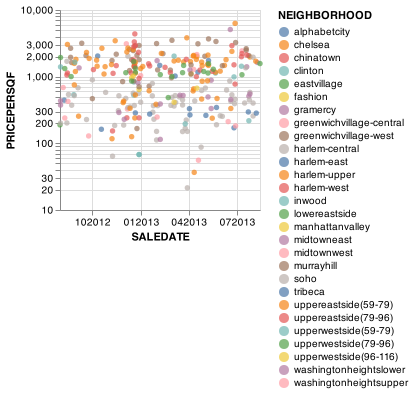

In [59]:
D_fam |> @vlplot(:circle,x={"SALEDATE:t",axis = {format="%m%Y"}},y={:PRICEPERSQF,scale={type="log",base=10}},color=:NEIGHBORHOOD)

Examining the 4 neighborhoods with the most family homes sold cuts out the noise and shows a clear separation between Harlem-Central and the other 3 neighbourhoods chosen. When considering the mean and median Price per sqf Greenwich Village West has the highest, followed by Upper Esat Side (59-79), UES (79-96), and Harlem Central was significantly lower. We also note that Upper East Side (79-96) has the largest standard deviation, highlighting that there is a lot of variation in price.

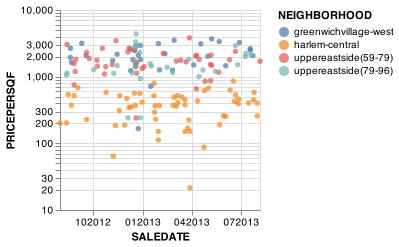

4×4 DataFrame
│ Row │ Key                   │ Mean    │ Median  │ Sigma   │
│     │ String                │ Float64 │ Float64 │ Float64 │
├─────┼───────────────────────┼─────────┼─────────┼─────────┤
│ 1   │ greenwichvillage-west │ 2177.77 │ 2086.01 │ 830.293 │
│ 2   │ harlem-central        │ 383.021 │ 376.138 │ 182.121 │
│ 3   │ uppereastside(59-79)  │ 1765.88 │ 1704.55 │ 728.565 │
│ 4   │ uppereastside(79-96)  │ 1692.99 │ 1446.76 │ 905.97  │


In [75]:
# Lets look solely at the 4 neighbourhoods with the most properties listed
p = D_fam |> @filter(_.NEIGHBORHOOD == "uppereastside(59-79)" || _.NEIGHBORHOOD == "harlem-central"|| _.NEIGHBORHOOD == "greenwichvillage-west" || _.NEIGHBORHOOD == "uppereastside(79-96)")|> @vlplot(:circle,x={"SALEDATE:t",axis = {format="%m%Y"}},y={:PRICEPERSQF,scale={type="log",base=10}},color=:NEIGHBORHOOD)
display(p)

println(D_fam |> @filter(_.NEIGHBORHOOD == "uppereastside(59-79)" || _.NEIGHBORHOOD == "harlem-central"|| _.NEIGHBORHOOD == "greenwichvillage-west" || _.NEIGHBORHOOD == "uppereastside(79-96)")|> @groupby(_.NEIGHBORHOOD)|>@map({Key=key(_), Mean=mean(_.PRICEPERSQF),Median = median(_.PRICEPERSQF),Sigma = std(_.PRICEPERSQF)})|>DataFrame)
    

From looking at the data suggests there have been no significant variation over time, which is to be expected as it is only 1 years worht of data.

Now we can take a look and see if the number of sales for our chosen Neighbourhoods has any trends over time.

In [299]:
# Lets split our data into some smaller data frames that we'll then process. 
DU59 = D_fam |> @filter(_.NEIGHBORHOOD == "uppereastside(59-79)" )|> @map({DATE = _.SALEDATE,PRICE = _.PRICEPERSQF, NEIGHBORHOOD = _.NEIGHBORHOOD}) |> DataFrame;
DU79 = D_fam |> @filter(_.NEIGHBORHOOD == "uppereastside(79-96)" )|> @map({DATE = _.SALEDATE,PRICE = _.PRICEPERSQF, NEIGHBORHOOD = _.NEIGHBORHOOD}) |> DataFrame;
DHC = D_fam |> @filter(_.NEIGHBORHOOD == "harlem-central" )|> @map({DATE = _.SALEDATE,PRICE = _.PRICEPERSQF, NEIGHBORHOOD = _.NEIGHBORHOOD}) |> DataFrame;
DGVW = D_fam |> @filter(_.NEIGHBORHOOD == "greenwichvillage-west" )|> @map({DATE = _.SALEDATE,PRICE = _.PRICEPERSQF, NEIGHBORHOOD = _.NEIGHBORHOOD}) |> DataFrame;

# We'll histogram the sales by month, I'm putting in a small offset in the dates so that when I plot histograms the bars do not overlap (I spent quite a long time on this trying to find a better solution but failed!)
function ym_to_date(x,off)
  return Dates.Date(x[1],x[2]) - Dates.Day(off)
end
DU59_hist = DU59 |> @groupby(Dates.yearmonth(_.DATE)) |> @map({DATE=ym_to_date(key(_),8), Count = length(_),NEIGHBORHOOD = unique(_.NEIGHBORHOOD)[1]})|> DataFrame
DU79_hist = DU79 |> @groupby(Dates.yearmonth(_.DATE)) |> @map({DATE=ym_to_date(key(_),3), Count = length(_),NEIGHBORHOOD = unique(_.NEIGHBORHOOD)[1]})|> DataFrame
DHC_hist = DHC |> @groupby(Dates.yearmonth(_.DATE)) |> @map({DATE=ym_to_date(key(_),-3), Count = length(_),NEIGHBORHOOD = unique(_.NEIGHBORHOOD)[1]})|> DataFrame
DGWV_hist = DGVW |> @groupby(Dates.yearmonth(_.DATE)) |> @map({DATE=ym_to_date(key(_),-8), Count = length(_),NEIGHBORHOOD = unique(_.NEIGHBORHOOD)[1]})|> DataFrame
# Combine the Data Frames ready for plotting
D_all = DataFrame(DATE = vcat(values(DU59_hist[:,:DATE]),values(DU79_hist[:,:DATE]),values(DHC_hist[:,:DATE]),values(DGWV_hist[:,:DATE])), Count = vcat(values(DU59_hist[:,:Count]),values(DU79_hist[:,:Count]),values(DHC_hist[:,:Count]),values(DGWV_hist[:,:Count])),NEIGHBORHOOD = vcat(values(DU59_hist[:,:NEIGHBORHOOD]),values(DU79_hist[:,:NEIGHBORHOOD]),values(DHC_hist[:,:NEIGHBORHOOD]),values(DGWV_hist[:,:NEIGHBORHOOD])));
D_all = D_all |> @orderby(_.DATE) |> DataFrame;

In [300]:
println(D_all)

45×3 DataFrame
│ Row │ DATE       │ Count │ NEIGHBORHOOD          │
│     │ Date       │ Int64 │ String                │
├─────┼────────────┼───────┼───────────────────────┤
│ 1   │ 2012-07-24 │ 5     │ uppereastside(59-79)  │
│ 2   │ 2012-07-29 │ 2     │ uppereastside(79-96)  │
│ 3   │ 2012-08-04 │ 5     │ harlem-central        │
│ 4   │ 2012-08-09 │ 3     │ greenwichvillage-west │
│ 5   │ 2012-08-24 │ 2     │ uppereastside(59-79)  │
│ 6   │ 2012-09-04 │ 2     │ harlem-central        │
│ 7   │ 2012-09-09 │ 2     │ greenwichvillage-west │
│ 8   │ 2012-09-23 │ 5     │ uppereastside(59-79)  │
│ 9   │ 2012-09-28 │ 1     │ uppereastside(79-96)  │
│ 10  │ 2012-10-04 │ 1     │ harlem-central        │
│ 11  │ 2012-10-24 │ 2     │ uppereastside(59-79)  │
│ 12  │ 2012-10-29 │ 2     │ uppereastside(79-96)  │
│ 13  │ 2012-11-04 │ 5     │ harlem-central        │
│ 14  │ 2012-11-09 │ 2     │ greenwichvillage-west │
│ 15  │ 2012-11-23 │ 8     │ uppereastside(59-79)  │
│ 16  │ 2012-11-28 │ 11    │ up

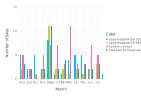

In [304]:
# Plot the histograms of sales per month. Looks like there was a spike in sales in December 2012. Without data for other years, it is not possible to say whether this is an outlier or it is a trend.
p1 = plot(x = D_all[:,:DATE],y=D_all[:,:Count],color = D_all[:,:NEIGHBORHOOD],Geom.bar,Guide.xlabel("Month"),Guide.ylabel("Number of Sales"))


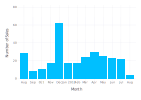

In [276]:
# Lets take a look at the larger dataset and see if there are any trends over time when looking at the whole of Manhattan
D_fam_hist = D_fam |> @groupby(Dates.yearmonth(_.SALEDATE)) |> @map({DATE=ym_to_date(key(_),0), Count = length(_)}) |> DataFrame;
p2 = plot(x = D_fam_hist[:,:DATE],y=D_fam_hist[:,:Count],Geom.bar,Guide.xlabel("Month"),Guide.ylabel("Number of Sales"))

Looks like there was a large spike in Sales during December of 2012. Lets get these sales into a new Data Frame and see where the sales are coming from.

In [286]:
D_fam_Dec = D_fam |> @filter(ym_to_date(Dates.yearmonth(_.SALEDATE),0) == Dates.Date("2012-12-01") )|> DataFrame;
println(D_fam_Dec |>
    @groupby(_.NEIGHBORHOOD) |>
    @map({Key=key(_), Count=length(_)}) |>
    DataFrame)

16×2 DataFrame
│ Row │ Key                      │ Count │
│     │ String                   │ Int64 │
├─────┼──────────────────────────┼───────┤
│ 1   │ clinton                  │ 2     │
│ 2   │ fashion                  │ 1     │
│ 3   │ gramercy                 │ 1     │
│ 4   │ greenwichvillage-central │ 5     │
│ 5   │ greenwichvillage-west    │ 11    │
│ 6   │ harlem-central           │ 7     │
│ 7   │ harlem-east              │ 1     │
│ 8   │ harlem-upper             │ 3     │
│ 9   │ manhattanvalley          │ 1     │
│ 10  │ murrayhill               │ 2     │
│ 11  │ soho                     │ 1     │
│ 12  │ uppereastside(59-79)     │ 8     │
│ 13  │ uppereastside(79-96)     │ 11    │
│ 14  │ upperwestside(59-79)     │ 2     │
│ 15  │ upperwestside(79-96)     │ 5     │
│ 16  │ upperwestside(96-116)    │ 1     │


Looks like Greenwich Village West & Upper East Side (79-96) is causing the spike in Family Homes sales during December 2012. Lets take a look at the larger dataset, no longer filtering 

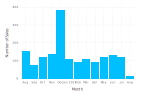

In [307]:
# Lets take a look at the larger dataset and see if there are any trends over time when looking at the whole of Manhattan
D_hist = D |> @groupby(Dates.yearmonth(_.SALEDATE)) |> @map({DATE=ym_to_date(key(_),0), Count = length(_)}) |> DataFrame;
p2 = plot(x = D_hist[:,:DATE],y=D_hist[:,:Count],Geom.bar,Guide.xlabel("Month"),Guide.ylabel("Number of Sales"))

In [306]:
D_Dec = D |> @filter(ym_to_date(Dates.yearmonth(_.SALEDATE),0) == Dates.Date("2012-12-01") )|> DataFrame;
println(D_Dec |>
    @groupby(_.NEIGHBORHOOD) |>
    @map({Key=key(_), Count=length(_)}) |>
    DataFrame)

36×2 DataFrame
│ Row │ Key                      │ Count │
│     │ String                   │ Int64 │
├─────┼──────────────────────────┼───────┤
│ 1   │ alphabetcity             │ 3     │
│ 2   │ chelsea                  │ 17    │
│ 3   │ chinatown                │ 7     │
│ 4   │ civiccenter              │ 3     │
│ 5   │ clinton                  │ 9     │
│ 6   │ eastvillage              │ 4     │
│ 7   │ fashion                  │ 14    │
│ 8   │ financial                │ 7     │
│ 9   │ flatiron                 │ 5     │
│ 10  │ gramercy                 │ 5     │
│ 11  │ greenwichvillage-central │ 12    │
│ 12  │ greenwichvillage-west    │ 19    │
│ 13  │ harlem-central           │ 24    │
│ 14  │ harlem-east              │ 10    │
│ 15  │ harlem-upper             │ 13    │
│ 16  │ harlem-west              │ 3     │
│ 17  │ inwood                   │ 7     │
│ 18  │ javitscenter             │ 2     │
│ 19  │ kipsbay                  │ 2     │
│ 20  │ littleitaly              │ 7   

It certainly looks like there was a spike during December 2012 and a lot of those sales, over 1 in 8, were located in the Upper East Side (79-96). We'll quickly take a look at another type of property now. First we'll see what are some of the more common property types.

In [311]:
println(D |>
    @groupby(_.BUILDINGCLASSCATEGORY) |>
    @map({Key=key(_), Count=length(_)}) |> @orderby_descending(_.Count)|>
    DataFrame)

24×2 DataFrame
│ Row │ Key                                 │ Count │
│     │ String                              │ Int64 │
├─────┼─────────────────────────────────────┼───────┤
│ 1   │ 07rentals-walkupapartments          │ 557   │
│ 2   │ 25luxuryhotels                      │ 187   │
│ 3   │ 08rentals-elevatorapartments        │ 158   │
│ 4   │ 01onefamilyhomes                    │ 127   │
│ 5   │ 02twofamilyhomes                    │ 106   │
│ 6   │ 22storebuildings                    │ 105   │
│ 7   │ 14rentals-4-10unit                  │ 93    │
│ 8   │ 21officebuildings                   │ 89    │
│ 9   │ 23loftbuildings                     │ 73    │
│ 10  │ 03threefamilyhomes                  │ 58    │
│ 11  │ 29commercialgarages                 │ 31    │
│ 12  │ 37religiousfacilities               │ 17    │
│ 13  │ 26otherhotels                       │ 13    │
│ 14  │ 30warehouses                        │ 13    │
│ 15  │ 11acondo-rentals                    │ 9     │
│ 16  │ 33edu

Looks like theres 557 Rental - Walkup Apartments in our dataset, lets make a few plots.

35×2 DataFrame
│ Row │ Key                      │ Count │
│     │ String                   │ Int64 │
├─────┼──────────────────────────┼───────┤
│ 1   │ harlem-central           │ 91    │
│ 2   │ uppereastside(79-96)     │ 59    │
│ 3   │ washingtonheightsupper   │ 36    │
│ 4   │ eastvillage              │ 30    │
│ 5   │ washingtonheightslower   │ 29    │
│ 6   │ harlem-east              │ 28    │
│ 7   │ uppereastside(59-79)     │ 28    │
│ 8   │ upperwestside(79-96)     │ 22    │
│ 9   │ lowereastside            │ 19    │
│ 10  │ chelsea                  │ 18    │
│ 11  │ manhattanvalley          │ 18    │
│ 12  │ clinton                  │ 16    │
│ 13  │ harlem-upper             │ 16    │
│ 14  │ alphabetcity             │ 15    │
│ 15  │ inwood                   │ 15    │
│ 16  │ greenwichvillage-west    │ 13    │
│ 17  │ gramercy                 │ 12    │
│ 18  │ upperwestside(59-79)     │ 12    │
│ 19  │ upperwestside(96-116)    │ 12    │
│ 20  │ harlem-west              │ 11  

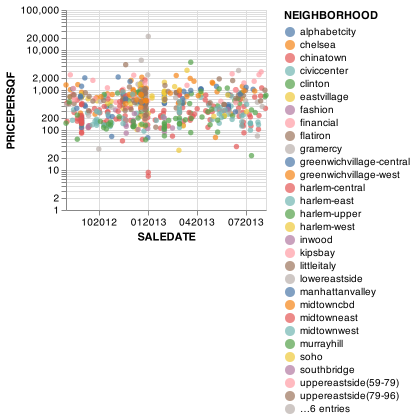

In [315]:
D_apt = D |> @filter(_.BUILDINGCLASSCATEGORY == "07rentals-walkupapartments") |> DataFrame;
# Lets see what neighbourhoods we're left with
println(D_apt |>
    @groupby(_.NEIGHBORHOOD) |>
    @map({Key=key(_), Count=length(_)}) |> @orderby_descending(_.Count)|>
    DataFrame)
D_apt |> @vlplot(:circle,x={"SALEDATE:t",axis = {format="%m%Y"}},y={:PRICEPERSQF,scale={type="log",base=10}},color=:NEIGHBORHOOD)

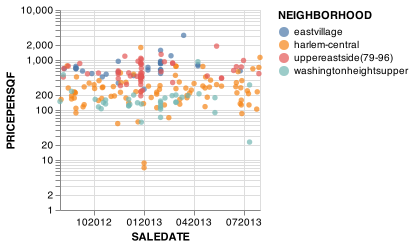

4×4 DataFrame
│ Row │ Key                    │ Mean    │ Median  │ Sigma   │
│     │ String                 │ Float64 │ Float64 │ Float64 │
├─────┼────────────────────────┼─────────┼─────────┼─────────┤
│ 1   │ eastvillage            │ 793.807 │ 673.79  │ 503.762 │
│ 2   │ harlem-central         │ 295.387 │ 232.613 │ 246.528 │
│ 3   │ uppereastside(79-96)   │ 613.198 │ 526.625 │ 292.945 │
│ 4   │ washingtonheightsupper │ 178.97  │ 143.086 │ 150.562 │


In [317]:
# Lets look solely at the 4 neighbourhoods with the most properties listed
p = D_apt |> @filter(_.NEIGHBORHOOD == "harlem-central" || _.NEIGHBORHOOD == "uppereastside(79-96)"|| _.NEIGHBORHOOD == "washingtonheightsupper" || _.NEIGHBORHOOD == "eastvillage")|> @vlplot(:circle,x={"SALEDATE:t",axis = {format="%m%Y"}},y={:PRICEPERSQF,scale={type="log",base=10}},color=:NEIGHBORHOOD)
display(p)

println(D_apt |> @filter(_.NEIGHBORHOOD == "harlem-central" || _.NEIGHBORHOOD == "uppereastside(79-96)"|| _.NEIGHBORHOOD == "washingtonheightsupper" || _.NEIGHBORHOOD == "eastvillage")|> @groupby(_.NEIGHBORHOOD)|>@map({Key=key(_), Mean=mean(_.PRICEPERSQF),Median = median(_.PRICEPERSQF),Sigma = std(_.PRICEPERSQF)})|>DataFrame)
    

In [320]:
# Lets split our data into some smaller data frames that we'll then process. 
DEV_apt = D_apt |> @filter(_.NEIGHBORHOOD == "eastvillage" )|> @map({DATE = _.SALEDATE,PRICE = _.PRICEPERSQF, NEIGHBORHOOD = _.NEIGHBORHOOD}) |> DataFrame;
DU79_apt = D_apt |> @filter(_.NEIGHBORHOOD == "uppereastside(79-96)" )|> @map({DATE = _.SALEDATE,PRICE = _.PRICEPERSQF, NEIGHBORHOOD = _.NEIGHBORHOOD}) |> DataFrame;
DHC_apt = D_apt |> @filter(_.NEIGHBORHOOD == "harlem-central" )|> @map({DATE = _.SALEDATE,PRICE = _.PRICEPERSQF, NEIGHBORHOOD = _.NEIGHBORHOOD}) |> DataFrame;
DWHU_apt = D_apt |> @filter(_.NEIGHBORHOOD == "washingtonheightsupper" )|> @map({DATE = _.SALEDATE,PRICE = _.PRICEPERSQF, NEIGHBORHOOD = _.NEIGHBORHOOD}) |> DataFrame;

# We'll histogram the sales by month, I'm putting in a small offset in the dates so that when I plot histograms the bars do not overlap (I spent quite a long time on this trying to find a better solution but failed!)
function ym_to_date(x,off)
  return Dates.Date(x[1],x[2]) - Dates.Day(off)
end
DEV_apt_hist = DEV_apt |> @groupby(Dates.yearmonth(_.DATE)) |> @map({DATE=ym_to_date(key(_),8), Count = length(_),NEIGHBORHOOD = unique(_.NEIGHBORHOOD)[1]})|> DataFrame
DU79_apt_hist = DU79_apt |> @groupby(Dates.yearmonth(_.DATE)) |> @map({DATE=ym_to_date(key(_),3), Count = length(_),NEIGHBORHOOD = unique(_.NEIGHBORHOOD)[1]})|> DataFrame
DHC_apt_hist = DHC_apt |> @groupby(Dates.yearmonth(_.DATE)) |> @map({DATE=ym_to_date(key(_),-3), Count = length(_),NEIGHBORHOOD = unique(_.NEIGHBORHOOD)[1]})|> DataFrame
DWHU_apt_hist = DWHU_apt |> @groupby(Dates.yearmonth(_.DATE)) |> @map({DATE=ym_to_date(key(_),-8), Count = length(_),NEIGHBORHOOD = unique(_.NEIGHBORHOOD)[1]})|> DataFrame
# Combine the Data Frames ready for plotting
D_all = DataFrame(DATE = vcat(values(DEV_apt_hist[:,:DATE]),values(DU79_apt_hist[:,:DATE]),values(DHC_apt_hist[:,:DATE]),values(DWHU_apt_hist[:,:DATE])), Count = vcat(values(DEV_apt_hist[:,:Count]),values(DU79_apt_hist[:,:Count]),values(DHC_apt_hist[:,:Count]),values(DWHU_apt_hist[:,:Count])),NEIGHBORHOOD = vcat(values(DEV_apt_hist[:,:NEIGHBORHOOD]),values(DU79_apt_hist[:,:NEIGHBORHOOD]),values(DHC_apt_hist[:,:NEIGHBORHOOD]),values(DWHU_apt_hist[:,:NEIGHBORHOOD])));
D_all = D_all |> @orderby(_.DATE) |> DataFrame;

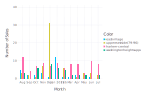

In [321]:
# Plot the histograms of sales per month. Looks like there was a spike in sales in December 2012. Without data for other years, it is not possible to say whether this is an outlier or it is a trend.
p1 = plot(x = D_all[:,:DATE],y=D_all[:,:Count],color = D_all[:,:NEIGHBORHOOD],Geom.bar,Guide.xlabel("Month"),Guide.ylabel("Number of Sales"))


Once again we see the large spike in December in the Upper Esat Side (79-96th Street). 